In the previous chapter, we observed that the KoLeo loss successfully spreads embeddings in the representation space. However, we noted that the KoLeo loss is intrinsically dependent on batch size: it computes the minimum distance between each embedding and all other embeddings within the same batch. This batch dependency naturally raises questions about the impact of *gradient accumulation* on training and the quality of embeddings.

## What is Gradient Accumulation?

Gradient accumulation is a technique that allows training with a larger effective batch size when memory constraints limit the actual batch size that can fit in GPU memory. Instead of updating the model weights after processing a single batch, gradient accumulation:

1. **Processes multiple smaller batches** sequentially
2. **Accumulates the gradients** from each batch without updating the weights
3. **Updates the model weights** only after processing all accumulated batches

Mathematically, if we have a batch size of $B$ and accumulate gradients over $N$ batches, the effective batch size becomes $N \times B$. The loss is typically averaged over each batch, and the gradients are summed (or averaged) across all accumulated batches before the weight update.

![Gradient accumulation illustration](../images/grad-acc.png)

For a standard loss function like the triplet loss, gradient accumulation is straightforward: the loss is computed independently for each batch, and the gradients can be safely accumulated. However, for batch-dependent losses like the KoLeo loss, the situation is more complex.

The KoLeo loss computes distances between all pairs of embeddings within a batch. When using gradient accumulation, each sub-batch computes its own KoLeo loss based only on embeddings within that sub-batch and then compute a mean of the KoLeo loss for all sub-batches.
This means the KoLeo loss "sees" only the local structure within each sub-batch, not the global structure across the entire effective batch

This raises an important question: **does gradient accumulation affect the behavior of the KoLeo loss, and if so, how does it impact the spread and quality of embeddings?**

## Gradient accumulation in action

### Gradient accumulation with a standard loss (BCE loss)

To illustrate how gradient accumulation works with a standard loss like BCE lets build a small model and instantiate a loss function and an optimizer.

In [1]:
import torch
from torch import nn

seed = 42
torch.manual_seed(seed)
simple_model = nn.Sequential(nn.Linear(2, 3, bias=False), nn.Linear(3, 1, bias=False), nn.Sigmoid())

In [2]:
def print_weights(model):
    for name, param in model.named_parameters():
        print(name)
        print("-"*10)
        print(param.data.numpy())

print_weights(simple_model)


0.weight
----------
[[ 0.5406104   0.5869042 ]
 [-0.16565566  0.6495563 ]
 [-0.15492962  0.14268756]]
1.weight
----------
[[-0.28108588  0.3390678   0.50895905]]


Let's run our model over all a batch of 4 samples.

In [3]:
loss_fn = nn.BCELoss()
batch_input = torch.randn(4, 2)
targets = torch.Tensor([0, 1, 0, 1]).unsqueeze(1)

outputs = simple_model(batch_input)
original_loss = loss_fn(outputs, targets)
print(original_loss.item())

0.5844024419784546


If we want to accumulate the gradients overs 4 sub-batches, each sub-batch will have 1 sample. We run the model 4 times, accumulating the loss of each sub-batch, and compute the mean loss. Here how to do it:

In [4]:
import copy

simple_model_gradacc = copy.deepcopy(simple_model)

grad_accum_steps = 4
sub_batch_size = len(batch_input) // grad_accum_steps
batch_losses = torch.zeros(grad_accum_steps)

for sub_batch_idx in range(grad_accum_steps):
    sub_batch_input = batch_input[(sub_batch_idx * sub_batch_size):((sub_batch_idx + 1) * sub_batch_size), ...]
    sub_batch_targets = targets[(sub_batch_idx * sub_batch_size):((sub_batch_idx + 1) * sub_batch_size), ...]

    sub_batch_outputs = simple_model_gradacc(sub_batch_input)
    sub_batch_loss_gradacc = loss_fn(sub_batch_outputs, sub_batch_targets)
    print(f"loss for sub-batch {sub_batch_idx}: {sub_batch_loss_gradacc}")

    batch_losses[sub_batch_idx] = sub_batch_loss_gradacc

loss_gradacc = batch_losses.mean()
print(f"mean loss: {loss_gradacc.item()}")


loss for sub-batch 0: 0.5325143933296204
loss for sub-batch 1: 0.5711992383003235
loss for sub-batch 2: 0.7103754281997681
loss for sub-batch 3: 0.5235207676887512
mean loss: 0.5844024419784546


We can see that the mean loss resulting from the gradient accumulation it's exactly the same as the loss computed from the original batch. This works, because the reduction mode of the [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) is `mean` by default.

> `torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')`


If we choose `sum` instead, we will have a total loss equal to the sum of each loss of each sample

In [5]:
batch_losses.sum().item()

2.3376097679138184

In [6]:
loss_sum_fn = nn.BCELoss(reduction='sum')
outputs = simple_model(batch_input)
sum_loss = loss_sum_fn(outputs, targets)
print(sum_loss.item())

2.3376097679138184


Ok, now let's compute the gradients of both models, with and without gradient accumulation.

In [7]:
from torch.optim import SGD

def print_gradients(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(name)
            print("-"*10)
            print(param.grad)


optimizer = SGD(simple_model.parameters(), lr=1)
optimizer.zero_grad()
original_loss.backward(retain_graph=True)
print("Gradients of the model without gradient accumulation:")
print_gradients(simple_model)
print("="*20)

optimizer_gradacc = SGD(simple_model_gradacc.parameters(), lr=1)
optimizer_gradacc.zero_grad()

for sub_batch_idx in range(grad_accum_steps):
    sub_batch_input = batch_input[(sub_batch_idx * sub_batch_size):((sub_batch_idx + 1) * sub_batch_size), ...]
    sub_batch_targets = targets[(sub_batch_idx * sub_batch_size):((sub_batch_idx + 1) * sub_batch_size), ...]

    sub_batch_outputs = simple_model_gradacc(sub_batch_input)
    sub_batch_loss_gradacc = loss_fn(sub_batch_outputs, sub_batch_targets)
    sub_batch_loss_gradacc.backward(retain_graph=True)


print("Gradients of the model with gradient accumulation:")
print_gradients(simple_model_gradacc)

Gradients of the model without gradient accumulation:
0.weight
----------
tensor([[-0.1107, -0.0319],
        [ 0.1335,  0.0385],
        [ 0.2004,  0.0578]])
1.weight
----------
tensor([[ 0.2796,  0.0086, -0.0448]])
Gradients of the model with gradient accumulation:
0.weight
----------
tensor([[-0.4428, -0.1278],
        [ 0.5342,  0.1541],
        [ 0.8018,  0.2314]])
1.weight
----------
tensor([[ 1.1185,  0.0343, -0.1792]])


The reason we see different gradient values for the model trained with and without gradient accumulation is due to how the loss is scaled in each approach. 

When we process the whole batch at once (without gradient accumulation), the loss function computes the average loss over the entire batch, and backpropagation accumulates gradients based on this average.

However, when we use gradient accumulation and process the batch in smaller sub-batches, we calculate the loss (usually averaged) for each sub-batch and call `.backward()` on each one. This ends up accumulating the gradients for *each sub-batch average* rather than for the full batch average, effectively scaling the gradients by the number of accumulation steps and making them larger than expected.

To fix this we need to ensure that the overall scale of the loss matches between the two methods. The most common way to do this is to divide the loss of each sub-batch by the number of accumulation steps before calling `.backward()`,  
In summary, when using gradient accumulation, always adjust your loss scaling to make sure gradients are computed as if you had done a single backward pass on the whole batch.


In [8]:
optimizer_gradacc.zero_grad()

for sub_batch_idx in range(grad_accum_steps):
    sub_batch_input = batch_input[(sub_batch_idx * sub_batch_size):((sub_batch_idx + 1) * sub_batch_size), ...]
    sub_batch_targets = targets[(sub_batch_idx * sub_batch_size):((sub_batch_idx + 1) * sub_batch_size), ...]

    sub_batch_outputs = simple_model_gradacc(sub_batch_input)
    sub_batch_loss_gradacc = loss_fn(sub_batch_outputs, sub_batch_targets) / grad_accum_steps # scale the loss by the number of accumulation steps
    sub_batch_loss_gradacc.backward(retain_graph=True)
    
print_gradients(simple_model_gradacc)

0.weight
----------
tensor([[-0.1107, -0.0319],
        [ 0.1335,  0.0385],
        [ 0.2004,  0.0578]])
1.weight
----------
tensor([[ 0.2796,  0.0086, -0.0448]])


We have now the same gradients, we can update our model weights to confirm we have exactly the same thing.

In [9]:
optimizer.step()
optimizer_gradacc.step()

print("Weights of the model without gradient accumulation:")
print_weights(simple_model)
print("Weights of the model with gradient accumulation:")
print_weights(simple_model_gradacc)

Weights of the model without gradient accumulation:
0.weight
----------
[[ 0.65131354  0.61885107]
 [-0.2991945   0.6110195 ]
 [-0.35537863  0.0848418 ]]
1.weight
----------
[[-0.56070507  0.33048445  0.5537596 ]]
Weights of the model with gradient accumulation:
0.weight
----------
[[ 0.65131354  0.61885107]
 [-0.2991945   0.6110195 ]
 [-0.35537863  0.0848418 ]]
1.weight
----------
[[-0.56070507  0.33048445  0.5537596 ]]


### Gradient accumulation with KoLeo loss

With a standard loss function like Binary Cross Entropy (BCE), gradient accumulation is straightforward because the loss over a batch is just the mean of the losses over each individual example, and BCE is additive and independent across examples. Given a batch of predictions $\hat{y}$ and targets $y$, the total BCE loss is:

$$
\mathcal{L}_{\text{BCE}} = \frac{1}{N} \sum_{i=1}^N \ell_{\text{BCE}}(\hat{y}_i, y_i)
$$

When we split a batch into sub-batches for gradient accumulation, and scale each sub-batch's loss by $1/$ (number of accumulation steps), the overall gradients are equivalent to those computed on the full batch, because

$$
\frac{1}{K} \sum_{k=1}^K  \sum_{i \in \text{sub-batch}_k} \ell_{\text{BCE}}(\hat{y}_i, y_i) = \frac{1}{N}\sum_{i=1}^{N} \ell_{\text{BCE}}(\hat{y}_i, y_i)
$$

where $ N = B \times K $

However, with the KoLeo loss, the situation is more complex. The KoLeo loss for a batch depends not only on individual samples, but on the distances between all possible pairs within the batch. If we split the batch into sub-batches and independently compute the KoLeo loss for each, we lose the pairwise structure across the whole batch. The result is that gradient accumulation with naive sub-batch loss scaling does not yield the same gradients as computing the KoLeo loss over the full batch.


$$
\frac{1}{K} \sum_{k=1}^K ( \frac{1}{B} \sum_{(i,j) \in \text{sub-batch}_k^2} -\log\left( \min_{j \ne i} \| f(x_i) - f(x_j) \| \right)) \neq \frac{1}{N}\sum_{i=1}^{N} -\log\left( \min_{j \ne i} \| f(x_i) - f(x_j) \| \right))
$$

We can verify this programatically, again you can found utils script in https://github.com/adlane98/koleo-study. 

In [10]:
from training_utils import KoLeoLoss

koleo_loss = KoLeoLoss()

torch.manual_seed(seed)

simple_model = nn.Sequential(nn.Linear(10, 3, bias=False), nn.Linear(3, 2, bias=False))
inputs = torch.randn(100, 10)
outputs = simple_model(inputs)
print("Loss without gradient accumulation:")
print(koleo_loss(outputs).item())

sub_batch_size = len(inputs) // grad_accum_steps
losses = torch.zeros(grad_accum_steps)
for idx in range(grad_accum_steps):
    sub_batch_inputs = inputs[(idx * sub_batch_size):((idx + 1) * sub_batch_size), ...]
    sub_batch_outputs = simple_model(sub_batch_inputs)
    sub_batch_loss = koleo_loss(sub_batch_outputs)
    losses[idx] = sub_batch_loss

print("Loss with gradient accumulation:")
print(losses.mean().item())

Loss without gradient accumulation:
4.714231491088867
Loss with gradient accumulation:
3.278782844543457


With this example, we confirm that the KoLeo loss is not the same with or without gradient accumulation. But is this a problem? In real training, can the accumulated KoLeo loss still be a good enough approximation that it doesn't break the training?

## Integrating gradient accumulation to our code

First, we will train the same network used in chapters 1 and 2, and set the seed to ensure the training is exactly reproducible as at the beginning of chapter 2. We introduce a new hyper-parameter `grad_accum_steps` and we will ensure that `batch_size % grad_accum_steps = 0`. Moreover we make sure that the dataset length is also a multiple of the batch size so we modify the validation split to 0.0524 because `0.0524 x 25000 = 1256` so that we have `25000 - 1256 = 23744` and `23744 % 64 = 0`.

In [11]:
import numpy as np

from training_utils import get_device, load_cifar10, build_triplets, create_datasets


seed = 42
device = get_device()
device = "cpu"
print(f"Device: {device}")

images, labels = load_cifar10("../cifar-10-python")
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

np.random.seed(seed)
triplets, triplets_labels = build_triplets(images, labels, n_neg=2500, seed=seed)
print(f"Triplets shape: {triplets.shape}")

batch_size = 64
grad_accum_steps = 4
assert batch_size % grad_accum_steps == 0
sub_batch_size = batch_size // grad_accum_steps

learning_rate = 5e-4
margin = 0.4
koleo_weight = 0.1
val_split = 0.05

train_dataset, val_dataset, val_triplets, val_labels = create_datasets(triplets, triplets_labels, val_split=val_split, seed=seed)

koleo_loss_fn = KoLeoLoss()

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

Device: cpu
Images shape: (50000, 32, 32, 3), Labels shape: (50000,)
Triplets shape: (25000, 3, 32, 32, 3)
Train: 23750, Val: 1250


We can write the new training loop, and we put the validation loop in `training_utils.py` because it's the same validation loop as in chapter 2. Note that they are several ways to implement gradient accumulation. For the sake of simplicity we make the choice to do it inside the training loop and transfer the data to device after splitting the whole batch size into sub batches because a batch of 64 like we've chosen fit in our memory. But in real world scenario the batch size potentially don't fit in your memory, so you have to either change how the dataloader is implemented or make something like [that](https://wandb.ai/wandb_fc/tips/reports/How-To-Implement-Gradient-Accumulation-in-PyTorch--VmlldzoyMjMwOTk5): 

```python
optimizer = ...
NUM_ACCUMULATION_STEPS = ...

for epoch in range(...):
    for idx, sample in enumerate(dataloader):
        inputs, labels = sample

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        loss = loss / NUM_ACCUMULATION_STEPS
        loss.backward()

        if ((idx + 1) % NUM_ACCUMULATION_STEPS == 0) or (idx + 1 == len(dataloader)):
            optimizer.step()
            optimizer.zero_grad()
```

If I don't do it this way it's also because I want to keep reproductibilty in how the dataloader returns data, at least for the first run.

In [12]:
from tqdm import tqdm
from training_utils import triplet_loss, validation_loop

def train_loop(net, grad_accum_steps, dataloader, optimizer, margin, koleo_weight, print_freq=100):
    net.train()
    loss_accum = 0.0
    epoch_loss = 0.0
    for batch_idx, (anc, pos, neg) in tqdm(enumerate(dataloader)):

        if len(anc) < 64:
            continue
        
        optimizer.zero_grad()

        for sub_batch_idx in range(grad_accum_steps):
            anc_sb = anc[(sub_batch_idx * sub_batch_size):((sub_batch_idx + 1) * sub_batch_size), ...]
            pos_sb = pos[(sub_batch_idx * sub_batch_size):((sub_batch_idx + 1) * sub_batch_size), ...]
            neg_sb = neg[(sub_batch_idx * sub_batch_size):((sub_batch_idx + 1) * sub_batch_size), ...]

            anc_sb, pos_sb, neg_sb = anc_sb.to(device), pos_sb.to(device), neg_sb.to(device)
            anc_feat, pos_feat, neg_feat = net(anc_sb), net(pos_sb), net(neg_sb)

            t_loss = triplet_loss(anc_feat, pos_feat, neg_feat, margin)
            all_embeddings = torch.cat([anc_feat, pos_feat, neg_feat], dim=0)
            k_loss = koleo_loss_fn(all_embeddings)
            if koleo_weight is not None:
                loss = t_loss + koleo_weight * k_loss
            else:
                loss = t_loss
            
            loss = loss / grad_accum_steps
            loss_accum += loss.item()
            epoch_loss += loss.item()
            loss.backward()

        optimizer.step()


        if (batch_idx + 1) % print_freq == 0:
            print(f"Batch {batch_idx+1}: Loss = {loss_accum / print_freq:.4f}")
            loss_accum = 0.0

    return epoch_loss / (batch_idx + 1)

In [13]:
from training_utils import setup_training_dir

epochs = 15

config = {
    "seed": seed, "batch_size": batch_size, "grad_accum_steps": grad_accum_steps, "learning_rate": learning_rate,
    "epochs": epochs, "margin": margin, "koleo_weight": koleo_weight, "val_split": val_split
}
save_dir, metrics_path, csv_headers = setup_training_dir("runs_koleo_gradacc", config)

In [14]:
import random

from torch.utils.data import DataLoader
from torchvision.models import VGG11_Weights

from training_utils import VGG11Embedding, print_metrics, log_metrics

train_losses = []
val_losses = []
best_auc = 0
best_epoch_path = None

device = "cpu"

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
if torch.mps.is_available():
    torch.mps.manual_seed(seed)

gt = torch.Generator()
gt.manual_seed(seed)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gt)

net = VGG11Embedding(weights=VGG11_Weights.IMAGENET1K_V1).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

val_metrics = validation_loop(net, val_loader, margin, koleo_weight, device)
print(f"Before training")
print_metrics(val_metrics)
log_metrics(metrics_path, csv_headers, 0, "", val_metrics)

for epoch_idx in range(epochs):
    train_loss = train_loop(net, grad_accum_steps, train_loader, optimizer, margin, koleo_weight)
    val_metrics = validation_loop(net, val_loader, margin, koleo_weight, device)
    val_losses.append(val_metrics['val_loss'])
    train_losses.append(train_loss)
        
    print(f"Epoch {epoch_idx+1} - train_loss: {train_loss:.4f}, val_loss: {val_metrics['val_loss']:.4f}, val_auc: {val_metrics['val_auc']:.4f}")
    print_metrics(val_metrics)
    log_metrics(metrics_path, csv_headers, epoch_idx + 1, train_loss, val_metrics)

    if val_metrics['val_auc'] > best_auc:
        best_auc = val_metrics['val_auc']
        if best_epoch_path is not None:
            best_epoch_path.unlink()
        best_epoch_path = save_dir / f'best_epoch_{epoch_idx+1}.pth'
        torch.save(net.state_dict(), best_epoch_path)
        print(f"New best AUC: {best_auc:.4f} at epoch {epoch_idx+1}")

KeyboardInterrupt: 

In [15]:
from pathlib import Path
from training_utils import VGG11Embedding
net = VGG11Embedding()
save_dir = Path("runs_koleo_gradacc/20251230_131112")

best_epoch_path = list((save_dir.glob('best_epoch_*.pth')))[0]
net.load_state_dict(torch.load(best_epoch_path))

<All keys matched successfully>

We can now compare the distance matrix and the embeddings with the ones obtained at chapter 2.

In [16]:
from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

def plot_distance_matrix_and_embeddings(
    dist_matrix,
    embeddings_2d,
    ellipse_params,
    labels_array,
    label_names,
    save_path=None,
    title_suffix="",
):
    fig, axes = plt.subplots(1, 2, figsize=(20, 9))
    
    col_labels = [f"{label_names[i]}" for i in range(len(label_names))]
    row_labels = [f"{label_names[i]}" for i in range(len(label_names))]
    
    sns.heatmap(
        dist_matrix,
        xticklabels=col_labels,
        yticklabels=row_labels,
        annot=True,
        fmt='.2f',
        cmap='viridis',
        cbar_kws={'label': 'Cosine Distance'},
        ax=axes[0]
    )
    
    axes[0].set_title(f'Distance Matrix{title_suffix}', fontsize=14)
    axes[0].set_xticks(range(len(col_labels)))
    axes[0].set_xticklabels(col_labels, rotation=45, ha='right')
    axes[0].set_yticks(range(len(row_labels)))
    axes[0].set_yticklabels(row_labels, rotation=0)
    
    pca_2d_df = pd.DataFrame({
        'PC1': embeddings_2d[:, 0],
        'PC2': embeddings_2d[:, 1],
        'Label': labels_array,
        'Class': [label_names[int(label)] for label in labels_array]
    })
    
    palette = sns.color_palette("tab10", n_colors=10)
    class_names = sorted(pca_2d_df['Class'].unique())
    color_map = {cls: palette[i] for i, cls in enumerate(class_names)}
    
    sns.scatterplot(
        data=pca_2d_df, x='PC1', y='PC2',
        hue='Class', palette=color_map,
        alpha=0.7, s=30, ax=axes[1]
    )
    
    for cls in class_names:
        ep = ellipse_params[cls]
        center, w, h, angle = ep["center"], ep["width"], ep["height"], ep["angle"]
        color = color_map[cls]
        
        ellipse = Ellipse(
            xy=center, width=w, height=h, angle=angle,
            facecolor=(*color, 0.12), edgecolor=color, linewidth=2
        )
        axes[1].add_patch(ellipse)
    
    axes[1].set_xlabel('PC1')
    axes[1].set_ylabel('PC2')
    axes[1].set_title(f'PCA 2D Projection of Embeddings by Class{title_suffix}', fontsize=14)
    axes[1].legend(title='Classes', bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Combined plot saved at {save_path}")
    
    plt.show()
    plt.close()
    
    same_class_dists = np.diag(dist_matrix)
    diff_class_dists = []
    for i in range(len(label_names)):
        for j in range(len(label_names)):
            if i != j:
                diff_class_dists.append(dist_matrix[i, j])
    
    print(f"\nIntra-class distance: mean={np.mean(same_class_dists):.4f}, std={np.std(same_class_dists):.4f}")
    print(f"Inter-class distance: mean={np.mean(diff_class_dists):.4f}, std={np.std(diff_class_dists):.4f}")
    print(f"Separation margin: {np.mean(diff_class_dists) - np.mean(same_class_dists):.4f}")



Combined plot saved at runs_koleo_gradacc/20251230_131112/distance_matrix_and_embeddings_gradacc.png


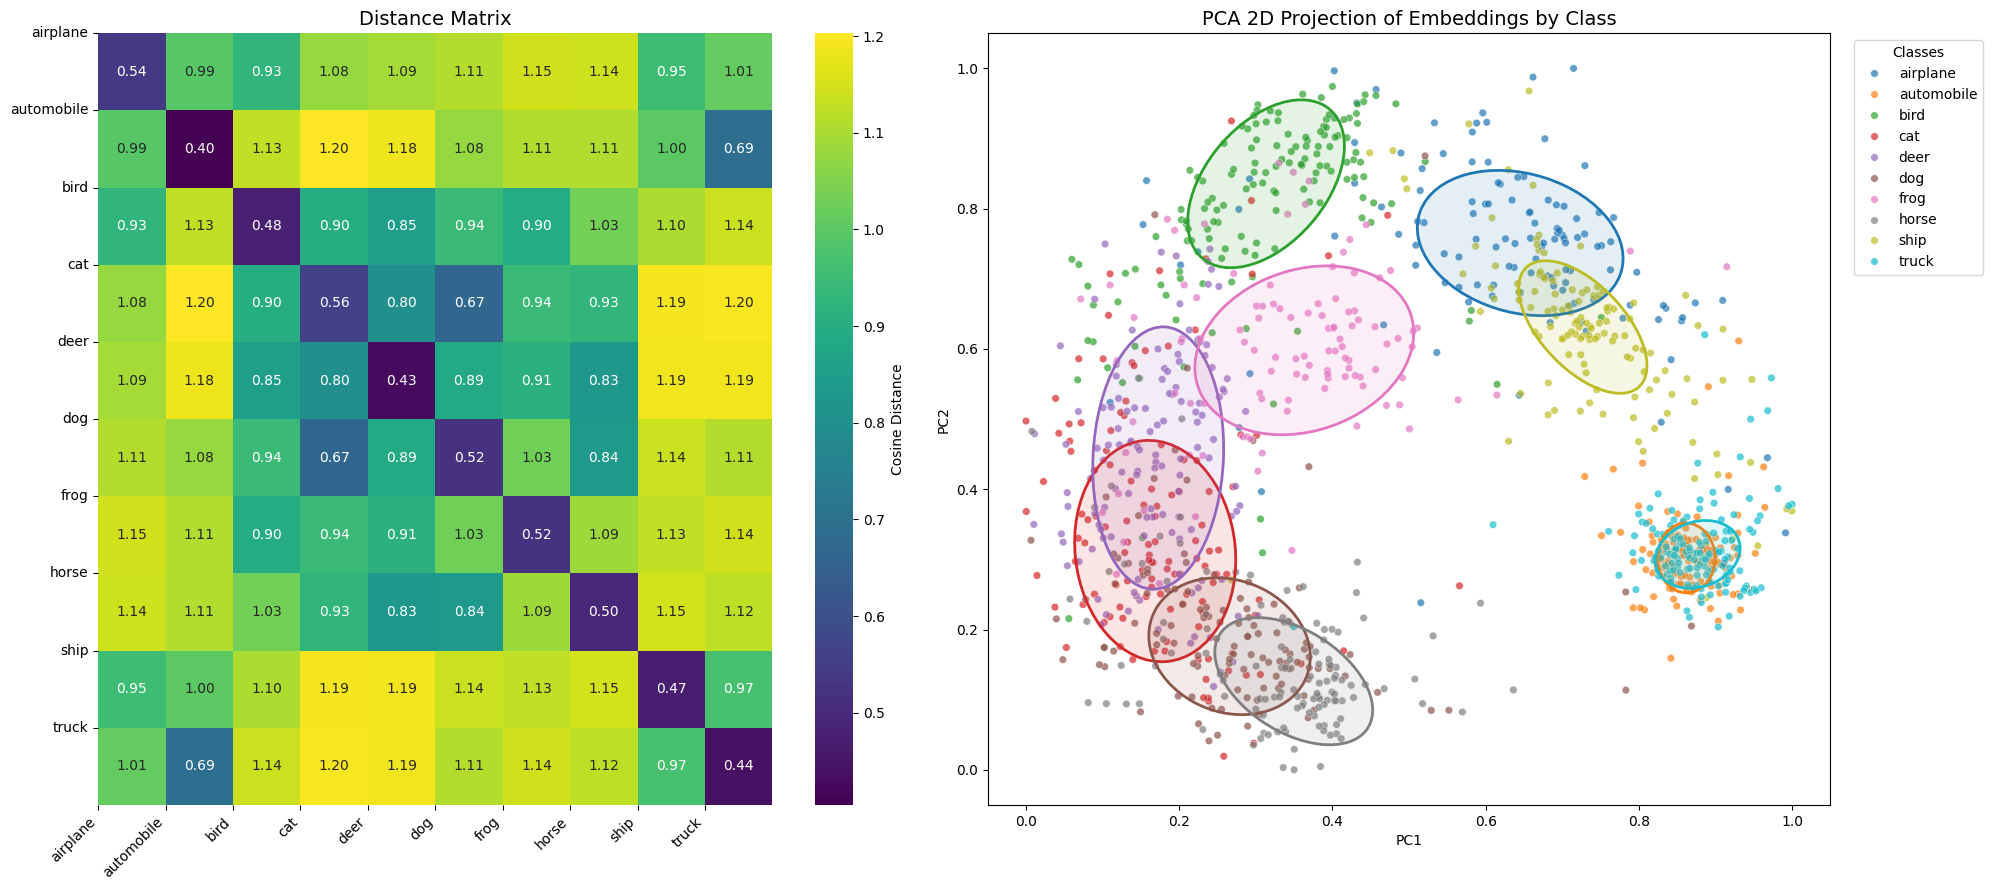


Intra-class distance: mean=0.4854, std=0.0488
Inter-class distance: mean=1.0279, std=0.1357
Separation margin: 0.5425


In [17]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

from plot_utils import compute_distance_matrix, get_ellipse_params_per_class
from training_utils import VAL_TRANSFORMS, construct_embeddings_by_class, LABEL_NAMES


embeddings_by_class = construct_embeddings_by_class(net, val_labels, val_triplets, VAL_TRANSFORMS, device)
dist_matrix = compute_distance_matrix(embeddings_by_class)

all_embeddings = torch.cat([embeddings_by_class[k] for k in embeddings_by_class], dim=0)

pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(all_embeddings)
embeddings_2d = (embeddings_2d - embeddings_2d.min(axis=0)) / (embeddings_2d.max(axis=0) - embeddings_2d.min(axis=0))
samples_per_class = [len(embeddings_by_class[i]) for i in range(10)]

labels_array = np.concatenate([np.full(count, label) for label, count in enumerate(samples_per_class)])
ellipse_params = get_ellipse_params_per_class(embeddings_2d, labels_array, LABEL_NAMES, coverage=0.5)

plot_distance_matrix_and_embeddings(dist_matrix, embeddings_2d, ellipse_params, labels_array, LABEL_NAMES, save_path=save_dir / "distance_matrix_and_embeddings_gradacc.png")


<div style="display: flex; gap: 10px;">
  <img src="../../runs_koleo/20251228_174908/distance_matrix_heatmap.png" alt="Image 1" style="width: 50%;"/>
  <img src="../../runs_koleo/20251228_174908/embeddings_2d_normalized.png" alt="Image 2" style="width: 50%;"/>
</div>

Here a table summarizing result we got in the two previous chapters. 

| Metric | Without KoLeo | With KoLeo | With KoLeo and gradient accumulation | 
|--------|---------------|------------|------------|
| Intra-class distance | mean=0.2249, std=0.0865 | mean=0.5202, std=0.0545 | mean=0.4854, std=0.0488 |
| Inter-class distance | mean=1.0392, std=0.2285 | mean=1.0350, std=0.1244 | mean=1.0279, std=0.1357 |
| Separation margin | 0.8143 | 0.5147 | 0.5425 |


With the gradient accumulmation results seems to be equivalent to the trainig with only KoLeo, but it's too early for such an affirmation. So to confirm this, we will do a new K-Fold training.

## K-Fold training

First we will initialize the K-Fold training. We also choose a negative sample to keep in the build triplets dataset to make sure every batch, even the last one, is exactly equal to 64. Indeed, in the case where we keep 2500 negative samples to keep, we would have 25000 samples, and `25000 * 0.95 = 23750` samples for training. But with 23750 and with a batch size of 64, the last batch will contains only 6 samples, becaause  `23750 % 64 = 6`. Since we have a gradient accumulaion steps of 4, each sub batch will contains 16 triplets except for the last 4 sub batches. The first of those 4 will contains 6 samples, and the next ones 0 because they are no more triplets . There are not enough triplets in the last batch.

In [18]:
import numpy as np
from training_utils import build_triplets,load_cifar10
images, labels = load_cifar10("../cifar-10-python")

np.random.seed(seed)
triplets, triplets_labels = build_triplets(images, labels, n_neg=2432, seed=seed)
print(triplets.shape)

(24320, 3, 32, 32, 3)


In [19]:
from sklearn.model_selection import KFold

import copy

K_FOLDS = 5
EPOCHS_PER_FOLD = 7

kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=seed)

device = get_device()

results_no_gradacc = {"areas": {cls: [] for cls in LABEL_NAMES}, "auc": []}
results_with_gradacc = {"areas": {cls: [] for cls in LABEL_NAMES}, "auc": []}


In [20]:
from training_utils import train_and_compute_metrics

for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(triplets)):
    print(f"\n{'='*50}")
    print(f"Fold {fold_idx + 1}/{K_FOLDS}")
    print(f"{'='*50}")
    
    fold_train_triplets = triplets[train_idx]
    fold_val_triplets = triplets[val_idx]
    fold_train_labels = triplets_labels[train_idx]
    fold_val_labels = triplets_labels[val_idx]
    
    print(f"Training WITHOUT gradient accumulation...")
    metrics_no_gradacc = train_and_compute_metrics(
        fold_train_triplets, 
        fold_val_triplets, 
        fold_val_labels,
        epochs=EPOCHS_PER_FOLD, 
        koleo_weight=0.1, 
        grad_accum_steps=4, 
    )
    for cls in LABEL_NAMES:
        results_no_gradacc["areas"][cls].append(metrics_no_gradacc["areas"][cls])
    results_no_gradacc["auc"].append(metrics_no_gradacc["auc"])
    print(f"  Best AUC: {metrics_no_gradacc['auc']:.4f}")
    
    print(f"Training WITH gradient accumulation...")
    metrics_with_gradacc = train_and_compute_metrics(
        fold_train_triplets, 
        fold_val_triplets, 
        fold_val_labels,
        epochs=EPOCHS_PER_FOLD, 
        koleo_weight=0.1, 
        grad_accum_steps=1, 
    )
    for cls in LABEL_NAMES:
        results_with_gradacc["areas"][cls].append(metrics_with_gradacc["areas"][cls])
    results_with_gradacc["auc"].append(metrics_with_gradacc["auc"])
    print(f"  Best AUC: {metrics_with_gradacc['auc']:.4f}")
    
    print(f"Fold {fold_idx + 1} done.")


Fold 1/5
Training WITHOUT gradient accumulation...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:55<00:00, 50.82s/it]


  Best AUC: 0.9135
Training WITH gradient accumulation...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:03<00:00, 34.83s/it]


  Best AUC: 0.9149
Fold 1 done.

Fold 2/5
Training WITHOUT gradient accumulation...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:21<00:00, 54.52s/it]


  Best AUC: 0.9210
Training WITH gradient accumulation...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:28<00:00, 38.37s/it]


  Best AUC: 0.9136
Fold 2 done.

Fold 3/5
Training WITHOUT gradient accumulation...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [1:23:34<00:00, 716.40s/it]


  Best AUC: 0.9165
Training WITH gradient accumulation...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:00<00:00, 34.40s/it]


  Best AUC: 0.9235
Fold 3 done.

Fold 4/5
Training WITHOUT gradient accumulation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [21:25<00:00, 183.57s/it]


  Best AUC: 0.9239
Training WITH gradient accumulation...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:02<00:00, 34.60s/it]


  Best AUC: 0.9251
Fold 4 done.

Fold 5/5
Training WITHOUT gradient accumulation...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:50<00:00, 50.04s/it]


  Best AUC: 0.9215
Training WITH gradient accumulation...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:36<00:00, 39.54s/it]


  Best AUC: 0.9111
Fold 5 done.


In [21]:
auc_no_gradacc = np.array(results_no_gradacc["auc"])
auc_with_gradacc = np.array(results_with_gradacc["auc"])

print("=" * 70)
print("AUC SCORES")
print("=" * 70)
print(f"Without gradient accumulation: {auc_no_gradacc.mean():.4f} +/- {auc_no_gradacc.std():.4f}")
print(f"With gradient accumulation: {auc_with_gradacc.mean():.4f} +/- {auc_with_gradacc.std():.4f}")

print("\n" + "=" * 70)
print("ELLIPSE AREAS")
print("=" * 70)
print(f"{'Class':<12} | {'Without KoLeo (mean +/- std)':<25} | {'With KoLeo (mean +/- std)':<25}")
print("-" * 70)

for cls in ["cat", "dog", "horse", "ship"]:
    no_gradacc_arr = np.array(results_no_gradacc["areas"][cls])
    with_gradacc_arr = np.array(results_with_gradacc["areas"][cls])
    
    print(f"{cls:<12} | {no_gradacc_arr.mean():.4f} +/- {no_gradacc_arr.std():.4f}        | {with_gradacc_arr.mean():.4f} +/- {with_gradacc_arr.std():.4f}")

print("\n" + "=" * 70)
print("Average area across all classes:")

all_no_gradacc = np.array([np.mean(results_no_gradacc["areas"][cls]) for cls in LABEL_NAMES])
all_with_gradacc = np.array([np.mean(results_with_gradacc["areas"][cls]) for cls in LABEL_NAMES])

print(f"  Without gradient accumulation: {all_no_gradacc.mean():.4f} +/- {all_no_gradacc.std():.4f}")
print(f"  With gradient accumulation: {all_with_gradacc.mean():.4f} +/- {all_with_gradacc.std():.4f}")

AUC SCORES
Without gradient accumulation: 0.9193 +/- 0.0037
With gradient accumulation: 0.9177 +/- 0.0056

ELLIPSE AREAS
Class        | Without KoLeo (mean +/- std) | With KoLeo (mean +/- std)
----------------------------------------------------------------------
cat          | 0.2119 +/- 0.0773        | 0.2169 +/- 0.0473
dog          | 0.1369 +/- 0.0475        | 0.1217 +/- 0.0358
horse        | 0.1474 +/- 0.0399        | 0.1438 +/- 0.0415
ship         | 0.0944 +/- 0.0272        | 0.0856 +/- 0.0233

Average area across all classes:
  Without gradient accumulation: 0.1479 +/- 0.0633
  With gradient accumulation: 0.1464 +/- 0.0581


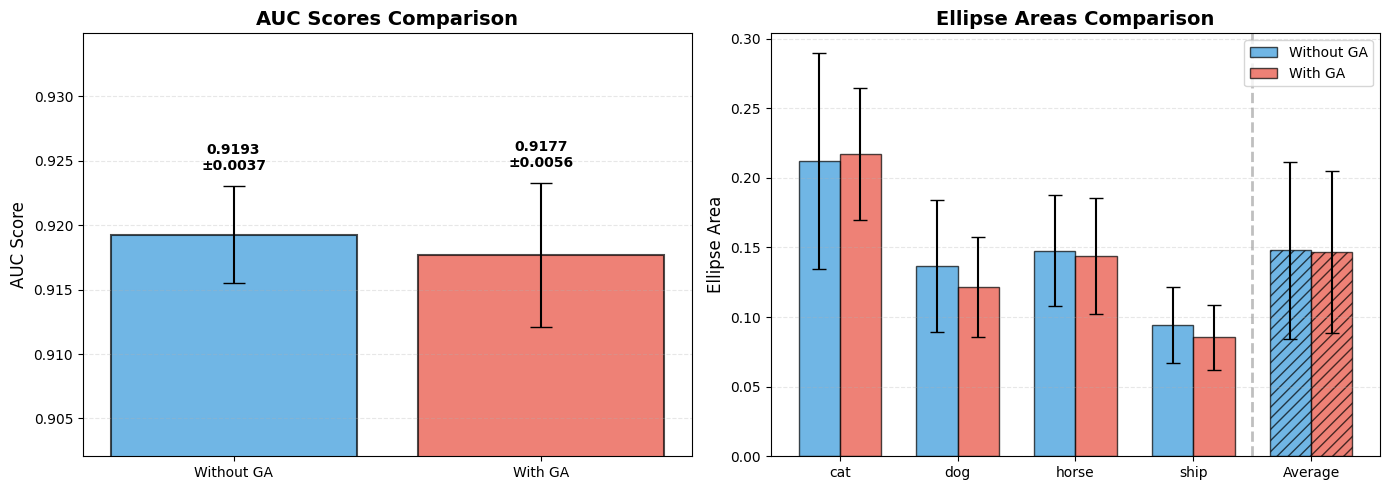

In [22]:
from plot_utils import plot_auc_and_ellipse_areas

plot_auc_and_ellipse_areas(
    results_no_gradacc,
    results_with_gradacc,
    ["Without GA", "With GA"],
    LABEL_NAMES,
)